# **Mini Project 3**
# Stock Price Prediction using the Sentiment Analysis of Twitter Data
By S M Zahid Hasan

# Fetching Data from Twitter

## Importing Snscrape to fetch twitter data

In [ ]:
!pip install snscrape
# Run the pip install command below if you don't already have the library
!pip install git+https://github.com/JustAnotherArchivist/snscrape.git
# Run the below command if you don't already have Pandas
!pip install pandas
# Imports
import snscrape.modules.twitter as sntwitter
import pandas as pd
import snscrape.modules.twitter as sntwitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-_ltjlze9
  Running command git clone -q https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-_ltjlze9
ERROR: Package 'snscrape' requires a different Python: 3.7.15 not in '~=3.8'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Fetching the data using snscrape and storing it in csv

In [ ]:
# Setting variables to be used below
maxTweets = 1000000
# Creating list to append tweet data to
tweets_list2 = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#AAPL since:2015-01-01 until:2022-11-04').get_items()):
  if i>maxTweets:
    break
  tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.username])

# Creating a dataframe from the tweets list above
tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
tweets_df2.to_csv("tweet.csv", index = False)

## Showing the last 5 of fetched data 

In [ ]:
tweets_df2.tail(5)

,Datetime,Tweet Id,Text,Username
200237,2015-01-01 01:30:03+00:00,550463934520504320,#AAPL:'Uber�-expensive fares on New Year�s Eve...,NewsMintApp
200238,2015-01-01 01:05:47+00:00,550457826662174720,#9joshi1991 #9lives #A4PChat #aap #AAPL #aas #...,___Z__Z__z_Z_Z
200239,2015-01-01 00:55:47+00:00,550455311275139073,#9joshi1991 #9lives #A4PChat #aap #AAPL #aas #...,___Z__Z__z_Z_Z
200240,2015-01-01 00:30:04+00:00,550448837026791424,#AAPL:Apple slapped with class action suit ove...,NewsMintApp
200241,2015-01-01 00:00:06+00:00,550441297652498433,Why is #MSFT is better than #AAPL? #Philanthro...,jeremeevans


# Importing libraries

In [ ]:
import tweepy
import csv
import pandas as pd
import random
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt

# Importing csv file

In [ ]:
tweets_df2 = pd.read_csv('tweet.csv')
tweets_df2.head(5)

# Data preprocessing

In [ ]:
tweets_df2 = tweets_df2.loc[(tweets_df2['Datetime'].str.contains("20")) & ~(tweets_df2['Datetime'].str.contains("#aapl"))]
tweets_df2.info

Cleaning the tweets and getting only Date from timestamp

In [ ]:
tweets_df2['Datetime'] = pd.to_datetime(tweets_df2['Datetime'])
tweets_df2['Datetime'] = tweets_df2['Datetime'].dt.date
#clean the tweets with a function
def cleanTweets(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text) #removes @mentions
    text = re.sub('#','',text) #removes hastag '#' symbol
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text
tweets_df2['cleanedTweets'] = tweets_df2['Text'].apply(cleanTweets) #apply cleanTweet function to the tweet
tweets_df2.head() #compares original tweets with cleaned Tweets

In [ ]:
tweets_df2.head()

,Datetime,Tweet Id,Text,Username,cleanedTweets
0,2022-11-03,1588308932191129600,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...,0919rento,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...
1,2022-11-03,1588304500577947648,アップルとスターバックス少量買い足ししました #AAPL #SBUX\n#米国株,m6WSqTzr9eWtvNT,アップルとスターバックス少量買い足ししました AAPL SBUX 米国株
2,2022-11-03,1588302628018335745,#AAPL worth as much as #META #AMZN #GOOG put t...,emilybarkerwork,AAPL worth as much as META AMZN GOOG put toget...
3,2022-11-03,1588290054413508608,#米国株 #AAPL\n companyName：Apple Inc...,finantialit,米国株 AAPL companyName：Apple Inc. ...
4,2022-11-03,1588290010536894464,おはようございます。 \n\nAppleは-4.24%\n\n一枚目：日足 移動平均\n二枚...,mekatanamaya,おはようございます。 Appleは-4.24% 一枚目：日足 移動平均 二枚目：日足 ...


Creating new DF with essential features and renaming the column name

In [ ]:
cdata = tweets_df2[['Datetime','cleanedTweets']].copy()
cdata.rename(columns = {'Datetime':'Date' , 'cleanedTweets':'Tweets'}, inplace = True)

Creating a dataframe where we will combine the tweets date wise and store into

In [ ]:
ccdata=pd.DataFrame(columns=['Date','Tweets'])

In [ ]:
indx=0
get_tweet=""
for i in range(0,len(cdata)-1):
    get_date=cdata.Date.iloc[i]
    next_date=cdata.Date.iloc[i+1]
    if(str(get_date)==str(next_date)):
        get_tweet=get_tweet+cdata.Tweets.iloc[i]+" "
    if(str(get_date)!=str(next_date)):
        temp_df = pd.DataFrame([[get_date, 
                                get_tweet]], columns = ['Date','Tweets'])
        ccdata = pd.concat([ccdata, temp_df], axis = 0).reset_index(drop = True)
        get_tweet=" "

In [ ]:
ccdata.head()

,Date,Tweets
0,2022-11-03,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...
1,2022-11-02,Profit Gang Today's trades 🤑🤑🤑 SPY AAP...
2,2022-11-01,"$SPY some bearishness, put divergence over ne..."
3,2022-10-31,$AAPL one of the most mentioned on 4chan over...
4,2022-10-30,AAPL Won't Introduce New M2 Macs Until Next Y...


Now to know the "closing price" of each day we will import STOCK PRICE DATA for AAPL from "yahoo.finance". We will consider "Close" price only.

In [ ]:
read_stock_p=pd.read_csv('AAPL.csv')
# DOWNLOAD UPDATED CLOSE PRICE FROM YAHOO FINANCE
read_stock_p

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.603209,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.910091,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.912346,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.247646,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.179298,237458000
...,...,...,...,...,...,...,...
1970,2022-10-28,148.199997,157.500000,147.820007,155.740005,155.482086,164762400
1971,2022-10-31,153.160004,154.240005,151.919998,153.339996,153.086044,97943200
1972,2022-11-01,155.080002,155.449997,149.130005,150.649994,150.400497,80379300
1973,2022-11-02,148.949997,152.169998,145.000000,145.029999,144.789810,93604600


Adding a "Price" column in our dataframe and fetching the stock price as per the date in our dataframe.

In [ ]:
ccdata['Prices']=""

In [ ]:
indx=0
for i in range (0,len(ccdata)):
    for j in range (0,len(read_stock_p)):
        get_tweet_date=ccdata.Date.iloc[i]
        get_stock_date=read_stock_p.Date.iloc[j]
        if(str(get_stock_date)==str(get_tweet_date)):
            ccdata['Prices'].iloc[i] = int(read_stock_p.Close[j])

Prices are fetched but some entires are blank as close price might not be available for that day due to some reason (like holiday, etc.)

In [ ]:
ccdata

,Date,Tweets,Prices
0,2022-11-03,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...,138
1,2022-11-02,Profit Gang Today's trades 🤑🤑🤑 SPY AAP...,145
2,2022-11-01,"$SPY some bearishness, put divergence over ne...",150
3,2022-10-31,$AAPL one of the most mentioned on 4chan over...,153
4,2022-10-30,AAPL Won't Introduce New M2 Macs Until Next Y...,
...,...,...,...
2858,2015-01-06,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26
2859,2015-01-05,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26
2860,2015-01-04,AAPL / : “That’s what the link-baiting press...,
2861,2015-01-03,"Vamos pata abajo Y aapl parece liderar "": $AA...",


So we take the mean for the close price and put it in the blank value

In [ ]:
mean=0
summ=0
count=0
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]!=""):
        summ=summ+int(ccdata.Prices.iloc[i])
        count=count+1
mean=summ/count
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]==""):
        ccdata.Prices.iloc[i]=int(mean)

#### Now all the entries have some value

In [ ]:
ccdata

,Date,Tweets,Prices
0,2022-11-03,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...,138
1,2022-11-02,Profit Gang Today's trades 🤑🤑🤑 SPY AAP...,145
2,2022-11-01,"$SPY some bearishness, put divergence over ne...",150
3,2022-10-31,$AAPL one of the most mentioned on 4chan over...,153
4,2022-10-30,AAPL Won't Introduce New M2 Macs Until Next Y...,71
...,...,...,...
2858,2015-01-06,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26
2859,2015-01-05,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26
2860,2015-01-04,AAPL / : “That’s what the link-baiting press...,71
2861,2015-01-03,"Vamos pata abajo Y aapl parece liderar "": $AA...",71


#### Making "prices" column as integer so mathematical operations could be performed easily.

In [ ]:
ccdata['Prices'] = ccdata['Prices'].apply(np.int64)

# Sentiment Analysis

## Adding 4 new columns in our dataframe so that sentiment analysis could be performed.. Comp is "Compound" it will tell whether the statement is overall negative or positive. If it has negative value then it is negative, if it has positive value then it is positive. If it has value 0, then it is neutral.

In [ ]:
ccdata["Comp"] = ''
ccdata["Negative"] = ''
ccdata["Neutral"] = ''
ccdata["Positive"] = ''
ccdata

,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,2022-11-03,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...,138,,,,
1,2022-11-02,Profit Gang Today's trades 🤑🤑🤑 SPY AAP...,145,,,,
2,2022-11-01,"$SPY some bearishness, put divergence over ne...",150,,,,
3,2022-10-31,$AAPL one of the most mentioned on 4chan over...,153,,,,
4,2022-10-30,AAPL Won't Introduce New M2 Macs Until Next Y...,71,,,,
...,...,...,...,...,...,...,...
2858,2015-01-06,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26,,,,
2859,2015-01-05,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26,,,,
2860,2015-01-04,AAPL / : “That’s what the link-baiting press...,71,,,,
2861,2015-01-03,"Vamos pata abajo Y aapl parece liderar "": $AA...",71,,,,


#### Downloading this package was essential to perform sentiment analysis.

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

#### This part of the code is responsible for assigning the polarity for each statement. That is how much positive, negative, neutral you statement is. And also assign the compound value that is overall sentiment of the statement.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in ccdata.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', ccdata.loc[indexx, 'Tweets'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        ccdata['Comp'].iloc[indexx] = sentence_sentiment['compound']
        ccdata['Negative'].iloc[indexx] = sentence_sentiment['neg']
        ccdata['Neutral'].iloc[indexx] = sentence_sentiment['neu']
        ccdata['Positive'].iloc[indexx] = sentence_sentiment['compound']
        # ccdata.set_value(indexx, 'Comp', sentence_sentiment['pos'])
        # ccdata.set_value(indexx, 'Negative', sentence_sentiment['neg'])
        # ccdata.set_value(indexx, 'Neutral', sentence_sentiment['neu'])
        # ccdata.set_value(indexx, 'Positive', sentence_sentiment['pos'])
    except TypeError:
        print (stocks_dataf.loc[indexx, 'Tweets'])
        print (indexx)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
ccdata

,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,2022-11-03,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...,138,0.9991,0.049,0.857,0.9991
1,2022-11-02,Profit Gang Today's trades 🤑🤑🤑 SPY AAP...,145,0.9971,0.044,0.884,0.9971
2,2022-11-01,"$SPY some bearishness, put divergence over ne...",150,0.9988,0.032,0.872,0.9988
3,2022-10-31,$AAPL one of the most mentioned on 4chan over...,153,0.9992,0.043,0.853,0.9992
4,2022-10-30,AAPL Won't Introduce New M2 Macs Until Next Y...,71,0.9988,0.031,0.889,0.9988
...,...,...,...,...,...,...,...
2858,2015-01-06,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26,0.9999,0.029,0.815,0.9999
2859,2015-01-05,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26,0.9995,0.029,0.866,0.9995
2860,2015-01-04,AAPL / : “That’s what the link-baiting press...,71,0.999,0.03,0.83,0.999
2861,2015-01-03,"Vamos pata abajo Y aapl parece liderar "": $AA...",71,0.9991,0.04,0.801,0.9991


#### Calculating the percentage of postive and negative tweets, and plotting the PIE chart for the same.

% of positive tweets=  94.72581208522529
% of negative tweets=  5.169402724414949


[]

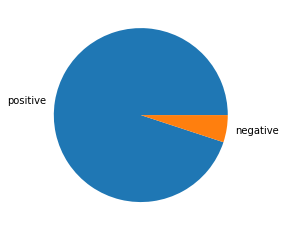

In [ ]:
posi=0
nega=0
for i in range (0,len(ccdata)):
    get_val=ccdata.Comp[i]
    if(float(get_val)<(0)):
        nega=nega+1
    if(float(get_val>(0))):
        posi=posi+1
posper=(posi/(len(ccdata)))*100
negper=(nega/(len(ccdata)))*100
print("% of positive tweets= ",posper)
print("% of negative tweets= ",negper)
arr=np.asarray([posper,negper], dtype=int)
mlpt.pie(arr,labels=['positive','negative'])
mlpt.plot()

# Making Data Ordinal for training 

In [ ]:
import datetime as dt
data = ccdata
data['Date']=data['Date'].map(dt.datetime.toordinal)

In [ ]:
data

,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,738462,危機感を覚えるとしたらハイテクジャイアント。AAPL、MSFT GOOGの売られ方が悪すぎる...,138,0.9991,0.049,0.857,0.9991
1,738461,Profit Gang Today's trades 🤑🤑🤑 SPY AAP...,145,0.9971,0.044,0.884,0.9971
2,738460,"$SPY some bearishness, put divergence over ne...",150,0.9988,0.032,0.872,0.9988
3,738459,$AAPL one of the most mentioned on 4chan over...,153,0.9992,0.043,0.853,0.9992
4,738458,AAPL Won't Introduce New M2 Macs Until Next Y...,71,0.9988,0.031,0.889,0.9988
...,...,...,...,...,...,...,...
2858,735604,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26,0.9999,0.029,0.815,0.9999
2859,735603,9joshi1991 9lives A4PChat aap AAPL aas AASCDB...,26,0.9995,0.029,0.866,0.9995
2860,735602,AAPL / : “That’s what the link-baiting press...,71,0.999,0.03,0.83,0.999
2861,735601,"Vamos pata abajo Y aapl parece liderar "": $AA...",71,0.9991,0.04,0.801,0.9991


# Training and Test Dataset

In [ ]:
X = data.drop(['Prices', 'Tweets'], axis = 1)
y = data['Prices']

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) # 80% training and 20% test

# Importing Libraries

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, max_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Prediction

In [ ]:
Performance = []
regressor_names = []

## MLP Regressor

In [ ]:
reg = make_pipeline(StandardScaler(), MLPRegressor())
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
print(f" r2 score: {r2_score(preds, y_test)}\n max error: {max_error(preds, y_test)}\n mean absolut error: {mean_absolute_error(preds, y_test)}")
Performance.append(round(r2_score(preds, y_test) * 100,2))
regressor_names.append('MLP with Normalization')

 r2 score: 0.5448965873205844
 max error: 79.89613005721245
 mean absolut error: 17.482140439018753


## Bayesian Ridge

In [ ]:
reg = make_pipeline(StandardScaler(), BayesianRidge())
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
# check different metrics
print(f" r2 score: {r2_score(preds, y_test)}\n max error: {max_error(preds, y_test)}\n mean absolut error: {mean_absolute_error(preds, y_test)}")
Performance.append(round(r2_score(preds, y_test) * 100,2))
regressor_names.append('Bayesian Ridge with Normalization')

 r2 score: 0.27743450007970216
 max error: 64.63264796128298
 mean absolut error: 21.68160028560767


## K Nearest Neighbours

In [ ]:
reg = make_pipeline(StandardScaler(), KNeighborsRegressor())
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
print(f" r2 score: {r2_score(preds, y_test)}\n max error: {max_error(preds, y_test)}\n mean absolut error: {mean_absolute_error(preds, y_test)}")
Performance.append(round(r2_score(preds, y_test) * 100,2))
regressor_names.append('KNN with Normalization')

 r2 score: 0.6970532695567517
 max error: 91.4
 mean absolut error: 13.56369982547993


# Performance Evaluation

In [ ]:
Performance 

[54.49, 27.74, 69.71]

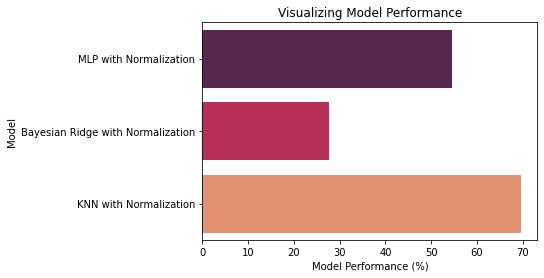

In [ ]:
import matplotlib.pyplot as plt
# Creating a bar plot
sns.barplot(x=Performance, y=regressor_names, palette= 'rocket')
# Add labels to your graph
plt.xlabel('Model Performance (%)')
plt.ylabel('Model')
plt.title("Visualizing Model Performance")
plt.show()